In [ ]:
pip install bing-image-downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from bing_image_downloader import downloader
import matplotlib.pyplot as plt


import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib

## Downloading Images

In [ ]:
#!mkdir /content/drive/MyDrive/Snailfish/failed_prints

In [ ]:
#downloader.download("failed 3D Print", limit= 1000, output_dir = "/content/drive/MyDrive/Snailfish/failed_prints")

In [ ]:
#downloader.download("failed 3d print example", limit= 250, output_dir = "/content/drive/MyDrive/Snailfish/failed_prints")

In [ ]:
#!mkdir /content/drive/MyDrive/Snailfish/successful_prints

In [ ]:
#downloader.download("3d printed parts", limit= 1000, output_dir = "/content/drive/MyDrive/Snailfish/successful_prints")

In [ ]:
#downloader.download("3d printed part", limit= 250, output_dir = "/content/drive/MyDrive/Snailfish/successful_prints")

## Building Model

## TensorFlow

https://www.tensorflow.org/tutorials/images/classification

In [ ]:
dir = '/content/drive/MyDrive/Snailfish'
success_dir = "/content/drive/MyDrive/Snailfish/successful_prints"


In [ ]:
# Identify Image Resolutions

# Import Packages
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

# Get the Image Resolutions
imgs = [img.name for img in Path(success_dir).iterdir() if img.suffix == ".jpg" or ".png"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(success_dir+'/'+f)

# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 248


<ipython-input-20-e41e2857c9ef>:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)


,FileName,Size,Width,Height,Aspect Ratio
0,Image_1.jpg,"(620, 465)",620,465,1.33
1,Image_3.png,"(1024, 512)",1024,512,2.00
2,Image_4 (1).jpg,"(1024, 978)",1024,978,1.05
3,Image_5 (1).jpg,"(1030, 579)",1030,579,1.78
4,Image_7.png,"(730, 399)",730,399,1.83


[(0.0, 2000.0), (0.0, 2000.0)]

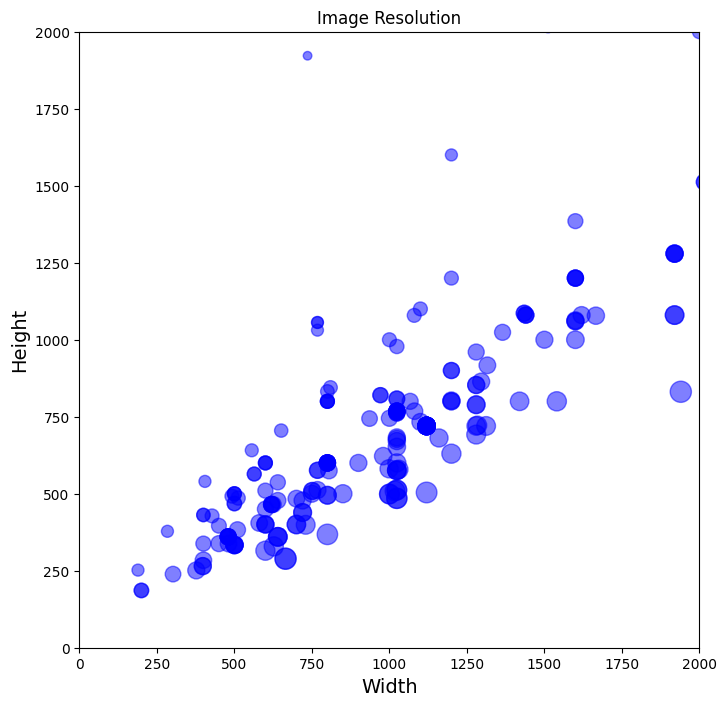

In [ ]:
#Find optimum image size. Want to find a balance to not under/over size a large portion of the sample size.


xmin = 0
xmax = 2000
ymin = 0
ymax = 2000
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="training",
  seed=15,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 486 files belonging to 2 classes.
Using 389 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=15,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 486 files belonging to 2 classes.
Using 97 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['failed_prints', 'successful_prints']


In [ ]:
# This cell identifies any images that are not accepted by tensorflow
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(assessment_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

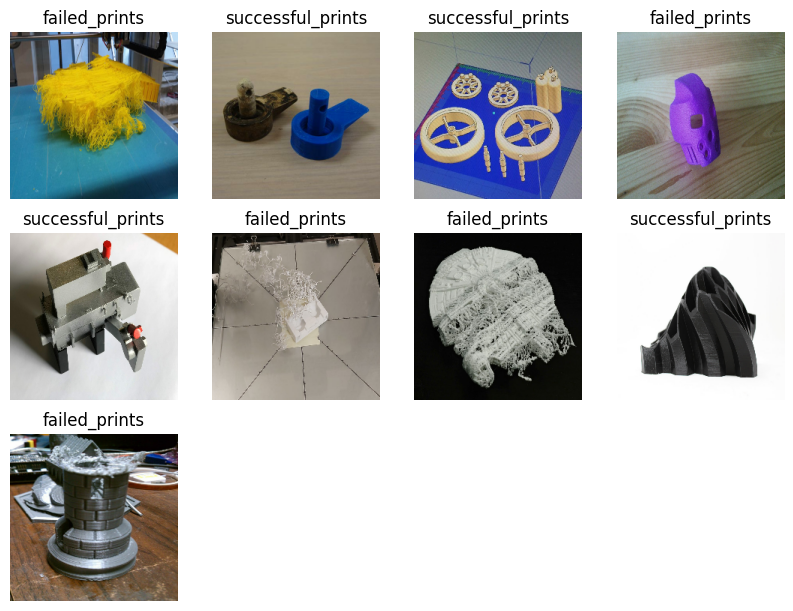

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    if images[i].numpy().dtype != np.dtype('O'):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 44s 2s/step - loss: 1.0882 - accuracy: 0.5630 - val_loss: 0.6504 - val_accuracy: 0.5773
Epoch 2/10
13/13 [==============================] - 25s 2s/step - loss: 0.6069 - accuracy: 0.6864 - val_loss: 0.6846 - val_accuracy: 0.6804
Epoch 3/10
13/13 [==============================] - 24s 2s/step - loss: 0.5415 - accuracy: 0.7198 - val_loss: 0.5426 - val_accuracy: 0.7010
Epoch 4/10
13/13 [==============================] - 27s 2s/step - loss: 0.3988 - accuracy: 0.7943 - val_loss: 0.5466 - val_accuracy: 0.7423
Epoch 5/10
13/13 [==============================] - 32s 3s/step - loss: 0.2820 - accuracy: 0.8946 - val_loss: 0.4514 - val_accuracy: 0.8041
Epoch 6/10
13/13 [==============================] - 24s 2s/step - loss: 0.1906 - accuracy: 0.9229 - val_loss: 0.6305 - val_accuracy: 0.7010
Epoch 7/10
13/13 [==============================] - 24s 2s/step - loss: 0.1365 - accuracy: 0.9614 - val_loss: 0.5318 - val_accuracy: 0.7835
Epoch 8/10
13/13 [==

In [ ]:
non_augmented_model = model.save("/content/drive/MyDrive/Print Assessment")

In [ ]:
model.save('/content/drive/MyDrive/Print Assessment/non_augmented_model.h5')

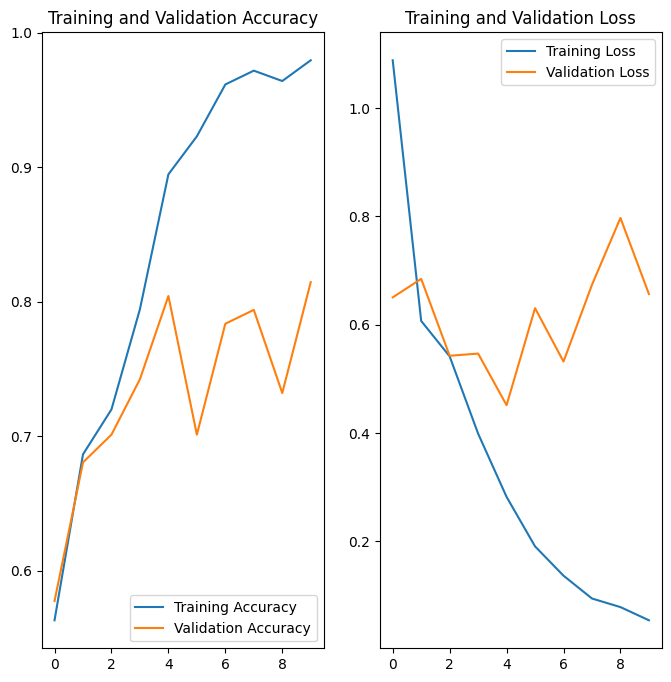

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model 2

In [ ]:
import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.4),
  ]
)

In [ ]:
model_2 = models.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 5, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 25
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
13/13 [==============================] - 36s 3s/step - loss: 0.5777 - accuracy: 0.6915 - val_loss: 0.6602 - val_accuracy: 0.5979
Epoch 2/25
13/13 [==============================] - 39s 3s/step - loss: 0.5551 - accuracy: 0.6735 - val_loss: 0.5670 - val_accuracy: 0.6907
Epoch 3/25
13/13 [==============================] - 38s 3s/step - loss: 0.5496 - accuracy: 0.7429 - val_loss: 0.5618 - val_accuracy: 0.7010
Epoch 4/25
13/13 [==============================] - 39s 3s/step - loss: 0.5332 - accuracy: 0.7301 - val_loss: 0.6285 - val_accuracy: 0.6495
Epoch 5/25
13/13 [==============================] - 36s 3s/step - loss: 0.5127 - accuracy: 0.7532 - val_loss: 0.5469 - val_accuracy: 0.7320
Epoch 6/25
13/13 [==============================] - 35s 3s/step - loss: 0.5080 - accuracy: 0.7584 - val_loss: 0.5314 - val_accuracy: 0.7320
Epoch 7/25
13/13 [==============================] - 37s 3s/step - loss: 0.5122 - accuracy: 0.7609 - val_loss: 0.5288 - val_accuracy: 0.7320
Epoch 8/25
13/13 [==

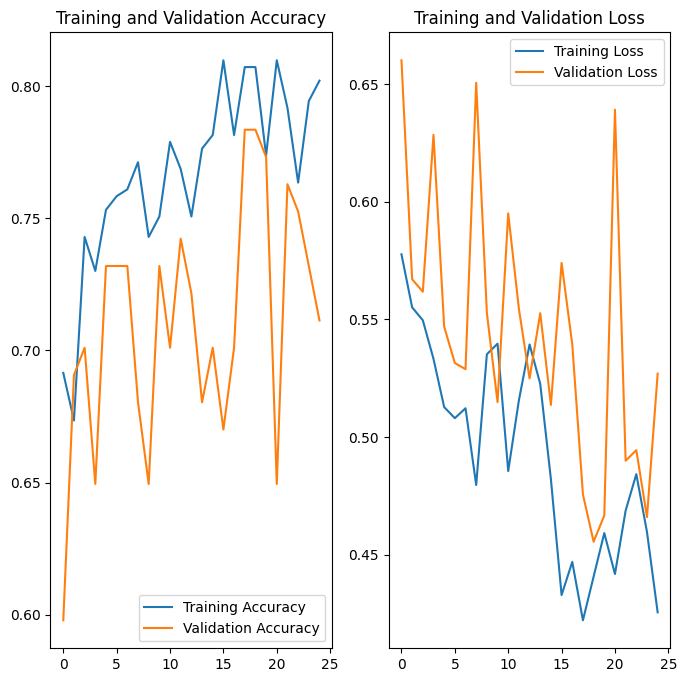

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/Print Assessment/IMG_2057.JPEG", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 50ms/step
This image most likely belongs to successful_prints with a 52.21 percent confidence.


In [ ]:
assessment_dir = "/content/drive/MyDrive/Print Assessment/IMG_2051.jpeg"
path = tf.keras.utils.image_dataset_from_directory(assessment_dir)
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

NotFoundError: ignored